## Does self-broadening and the diluents work?

In [6]:
%%capture
%load_ext autoreload
%autoreload 2
import os, sys
import copy
parent = os.path.dirname(os.getcwd())
sys.path.append(parent)
from classes import Spectra, Observer, HiddenPrints

Using data

CH4
                     Lines parsed: 588
H2O
                     Lines parsed: 91
NH3
                     Lines parsed: 27


#### Tasks
1. Ist **Selbstverbreiterung** berücksichtigt?  
    a) Per default?  
    b) Per  Diluent={'self': mfrac, 'air': (1 - mfrac)} 
        - Falls nein -> Use cgs Data (HITRAN_Units = True) https://github.com/hapijs/hapi/issues/4206   
2. Funktionieren **andere Diluents**, außer „selbst“ und „air“?
    - Der Diluent gamma-Parameter bestimmt das Colissional broadening.   
         - Warum brauche ich für jede Linie ein extra Gamma-X (x =air, self, …)? 
             - *Vermutlich* beeinflusst der Schwingungszustand des angeregten Molekühls den Kollisions-Wirkungsquerschnitt. (to verify - Tommy, Benni)
             - If so: Wie kann dann der Diluent berechnet werden? Maximal ist ein Standard collison-Crosssection hinterlegt, aber keine pro Linie.

##### Selbstverbreiterung
###### 1a)
    Step 1: NH3 in verschiedenen Konzentrationen

In [7]:
#%% 1. create a spectrum
my_spectrum = Spectra(name = 'Selbstverbreiterung NH3')

#%% 2. add an observer
my_spectrum.observer = Observer(unit  = 'lam',      #'wav' : wavenumer [1/cm] | 'lam' : wavelength [nm]
                                lower =  2927.5,    
                                upper =  2929,   
                                )

#%% 3. add gas_cells
# cell 0 - per default
my_spectrum.add_gas_cell(temperature    = 296,          # K
                         pressure       = 0.3,         # atm
                         length         = 0.1,         # cm
                         no_gasses      = 1)            # number of gasses)
my_spectrum.gas_cells[-1].add_gas(gas_name  = "NH3",
                                  VMR       = 5E-1)

# cell 1 - air
my_spectrum.add_gas_cell(temperature    = 296,          # K
                         pressure       = 0.3,          # atm
                         length         = 0.1,          # cm
                         no_gasses      = 1)            # number of gasses)
my_spectrum.gas_cells[-1].add_gas(gas_name  = "NH3",
                                  VMR       = 5E-2)


####################################### 
Added NH3 to the gas cell. 
*1/1 gasses are now in the cell: 
['NH3']
####################################### 
Added NH3 to the gas cell. 
*1/1 gasses are now in the cell: 
['NH3']


In [8]:
#%% 4. download (running hapi functions)
with HiddenPrints():            # disables hapi stdout
    my_spectrum.download(line_list      = False,    #by setting to false, the linelist will nor be downloaded nor plotted.
                          min_intensity = 5E-23 )   

Now - **nomalize** the two spectra, to see if their shape mateches.


In [9]:
my_spectrum_normalized = copy.deepcopy(my_spectrum)
my_spectrum_normalized.name += ' normalized'
for cell in my_spectrum_normalized.gas_cells:
    my_max = max(cell.absorp_lam)
    cell.absorp_lam = cell.absorp_lam/my_max


Summary of the spectum Selbstverbreiterung NH3: 
	 lower: 2927.5 [nm] 
	 upper: 2929 [nm] 
Gas cell 0: 
	 length: 0.1 cm | temp: 296 K|pressure: 0.3 atm|gas matrix: {'air': 0.5, 'self': 0.5} 
	 Gasses (VMR): 
	 	 NH3: 0.5 
Gas cell 1: 
	 length: 0.1 cm | temp: 296 K|pressure: 0.3 atm|gas matrix: {'air': 0.95, 'self': 0.05} 
	 Gasses (VMR): 
	 	 NH3: 0.05 



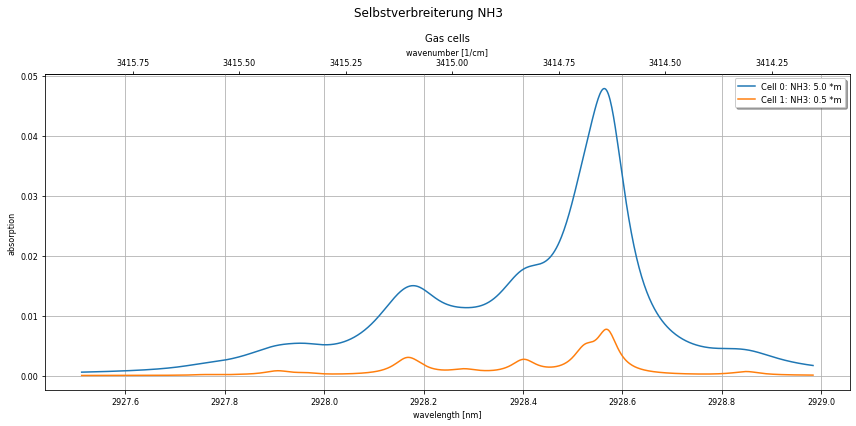

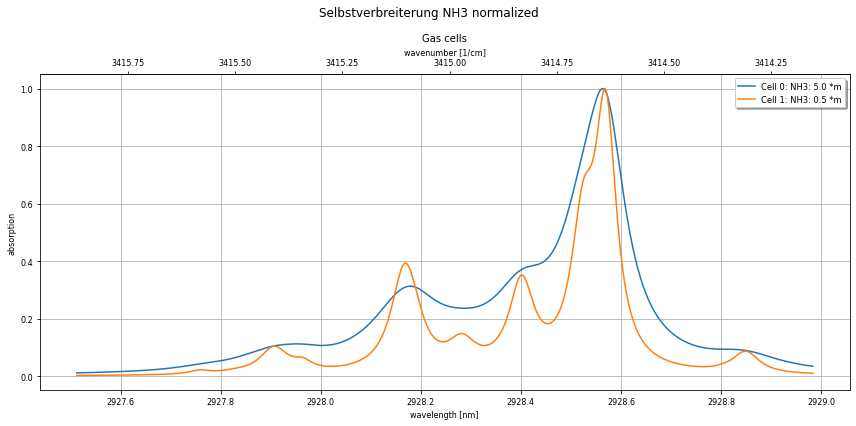

In [10]:
#%% 5. plot
print(my_spectrum)
my_spectrum.plot(figsize = (12,6))
my_spectrum_normalized.plot(figsize = (12,6))

*Interpretation:*   
    - Self broadening **not** included  
    - Where does the difference in the lineshape come from?  

   **1 b)**  
Using diluent: {'self': mfrac, 'air': (1 - mfrac)} 

{'air': 0.5, 'self': 0.5}
{'air': 0.95, 'self': 0.05}


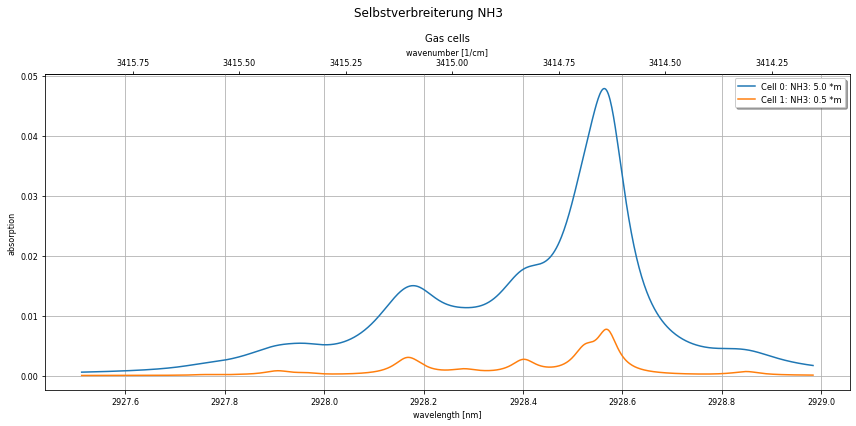

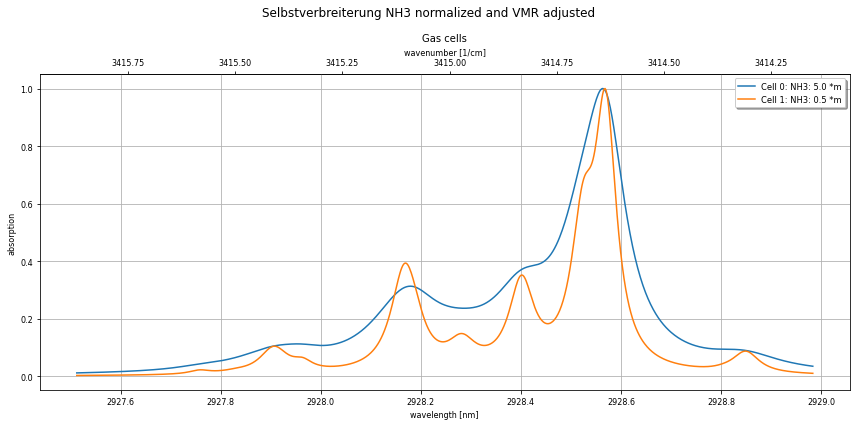

In [11]:
my_spectrum_1b = copy.deepcopy(my_spectrum)

# change diluent in the two gas_cells
for cell in my_spectrum_1b.gas_cells:
    VMR = cell.gasses[-1].VMR
    cell.diluent = {'air': 1 - VMR, 'self': VMR}
    print(cell.diluent)
    
# download again
with HiddenPrints():            # disables hapi stdout
    my_spectrum_1b.download(line_list      = False,    #by setting to false, the linelist will nor be downloaded nor plotted.
                            min_intensity = 5E-23 )   

# normalize again
my_spectrum_normalized_1b = copy.deepcopy(my_spectrum_1b)
my_spectrum_normalized_1b.name += ' normalized and VMR adjusted'
for cell in my_spectrum_normalized_1b.gas_cells:
    my_max = max(cell.absorp_lam)
    cell.absorp_lam = cell.absorp_lam/my_max
    
# plot 

my_spectrum_1b.plot(figsize = (12,6))
my_spectrum_normalized_1b.plot()

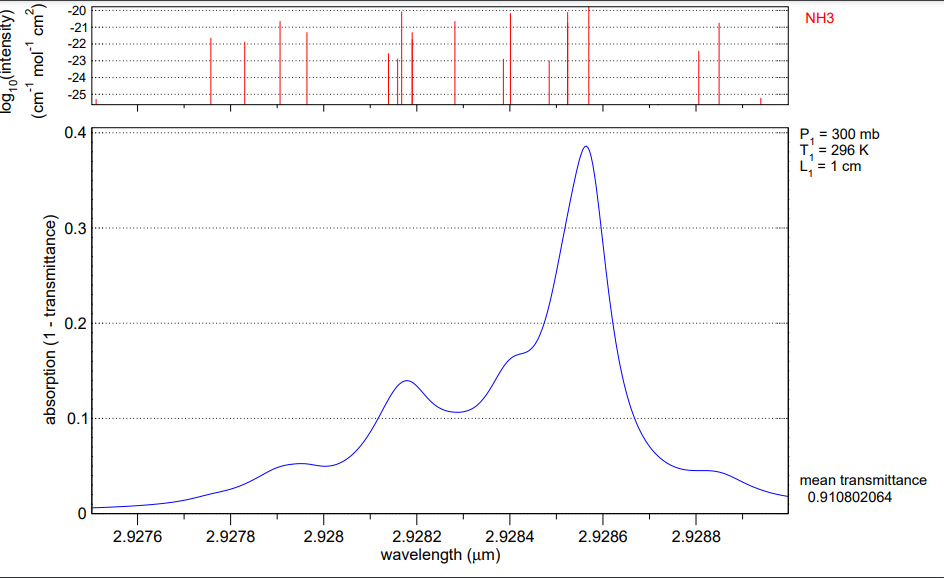*Here the spectracalc comparison*:  




*Interpretation:*   
    - Self broadening **is** included  
    - Is the VMR the correct way to adress? Or molefraction?

**1bx)** Hitran units

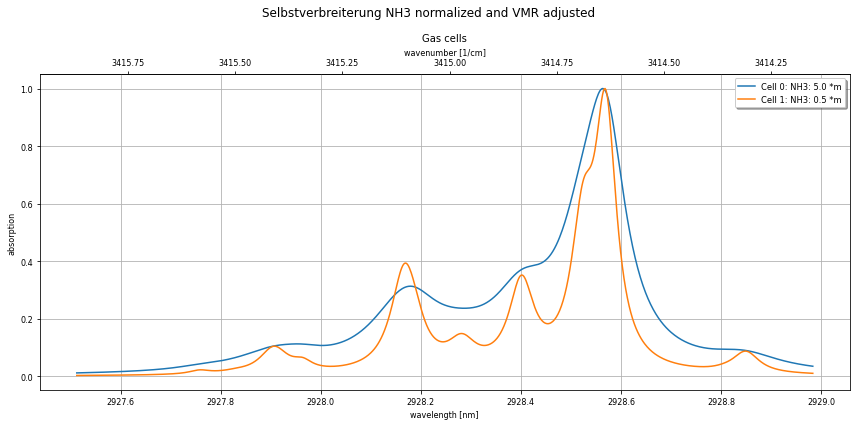

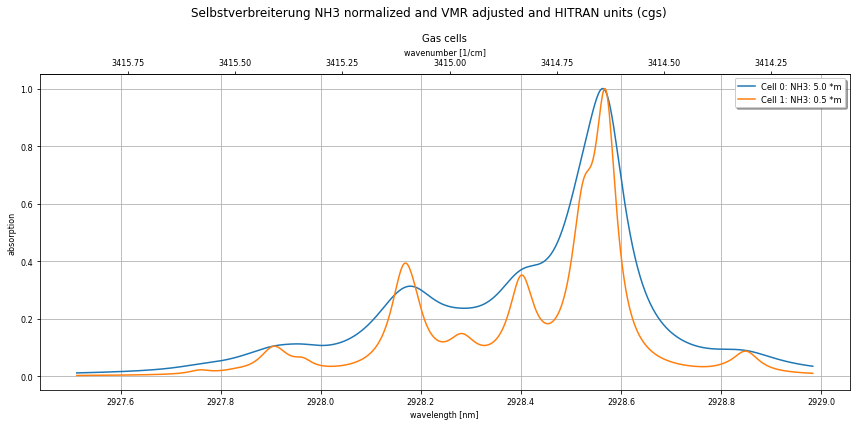

In [12]:
my_spectrum_1bx = copy.deepcopy(my_spectrum_1b)

# download again - with HITRAN unit True
with HiddenPrints():            # disables hapi stdout
    my_spectrum_1bx.download(line_list      = False,    #by setting to false, the linelist will nor be downloaded nor plotted.
                            min_intensity = 5E-23,
                            HITRAN_units = True)   # DOES NOT CHANGE ANYTHING :-)

# normalize again
my_spectrum_normalized_1bx = copy.deepcopy(my_spectrum_1bx)
my_spectrum_normalized_1bx.name += ' normalized and VMR adjusted and HITRAN units (cgs)'
for cell in my_spectrum_normalized_1bx.gas_cells:
    my_max = max(cell.absorp_lam)
    cell.absorp_lam = cell.absorp_lam/my_max
    
# plot 
my_spectrum_normalized_1b.plot()
my_spectrum_normalized_1bx.plot()

2. Funktionieren **andere Diluents**, außer „selbst“ und „air“?
    - Der Diluent gamma-Parameter bestimmt das Colissional broadening.   
         - Warum brauche ich für jede Linie ein extra Gamma-X (x =air, self, …)? 
             - *Vermutlich* beeinflusst der Schwingungszustand des angeregten Molekühls den Kollisions-Wirkungsquerschnitt. (to verify - Tommy, Benni)
             - If so: Wie kann dann der Diluent berechnet werden? Maximal ist ein Standard collison-Crosssection hinterlegt, aber keine pro Linie.

In [13]:
### This does not work anymore, as diluent was taken out from frontend. It is now automatically set to air - self. see 221204_Status_Bergau.pptx

#%% 1. create a spectrum
my_diluent_spectrum = Spectra(name = 'Diluent_Test')

#%% 2. add an observer
my_diluent_spectrum.observer = Observer(unit  = 'lam',      #'wav' : wavenumer [1/cm] | 'lam' : wavelength [nm]
                                lower =  2927.5,    
                                upper =  2929,   
                                )

#%% 3. add gas_cells
# cell 0 - in air
my_diluent_spectrum.add_gas_cell(temperature    = 296,          # K
                         pressure       = 0.3,         # atm
                         length         = 1,            # cm
                         diluent        = {'air':1},    # this is the default
                         no_gasses      = 1)            # number of gasses)
my_diluent_spectrum.gas_cells[-1].add_gas(gas_name  = "NH3",
                                  VMR       = 5E-1)

# cell 1 - in Nydrogen
my_diluent_spectrum.add_gas_cell(temperature    = 296,          # K
                         pressure       = 0.3,         # atm
                         length         = 1,            # cm
                         diluent        = {'N2':1}, 
                         no_gasses      = 1)            # number of gasses)
my_diluent_spectrum.gas_cells[-1].add_gas(gas_name  = "NH3",
                                  VMR       = 5E-1)

# cell 2 - in hydrogen
my_diluent_spectrum.add_gas_cell(temperature    = 296,          # K
                         pressure       = 0.3,         # atm
                         length         = 1,            # cm
                         diluent        = {'H2':1}, 
                         no_gasses      = 1)            # number of gasses)
my_diluent_spectrum.gas_cells[-1].add_gas(gas_name  = "NH3",
                                  VMR       = 5E-1)

#%% 4. download (running hapi functions)
with HiddenPrints():            # disables hapi stdout
    my_diluent_spectrum.download(line_list      = False,    #by setting to false, the linelist will nor be downloaded nor plotted.
                                min_intensity = 5E-23 )   

TypeError: add_gas_cell() got an unexpected keyword argument 'diluent'

Summary of the spectum Diluent_Test: 
	 lower: 2927.5 [nm] 
	 upper: 2929 [nm] 
Gas cell 0: 
	 length: 1 cm | temp: 296 K|pressure: 0.3 atm|diluent: {'air': 1} 
	 Gasses: 
	 	 NH3: 0.5 
Gas cell 1: 
	 length: 1 cm | temp: 296 K|pressure: 0.3 atm|diluent: {'N2': 1} 
	 Gasses: 
	 	 NH3: 0.5 
Gas cell 2: 
	 length: 1 cm | temp: 296 K|pressure: 0.3 atm|diluent: {'H2': 1} 
	 Gasses: 
	 	 NH3: 0.5 



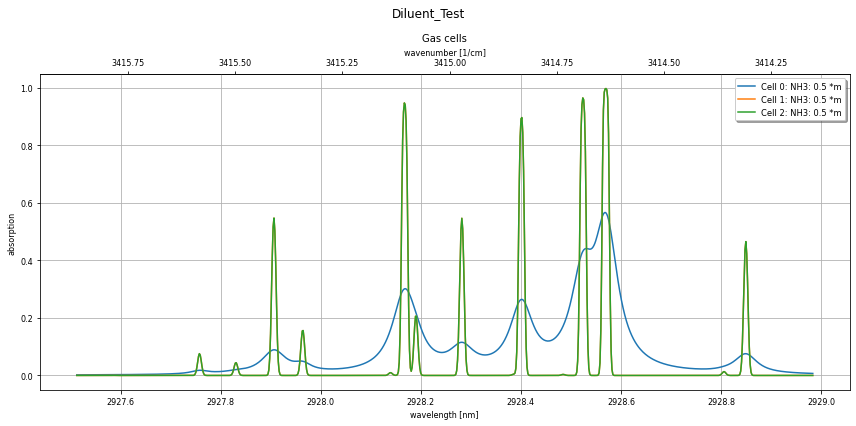

In [33]:
print(my_diluent_spectrum)
my_diluent_spectrum.plot()

Not with Hitran units (cgs)

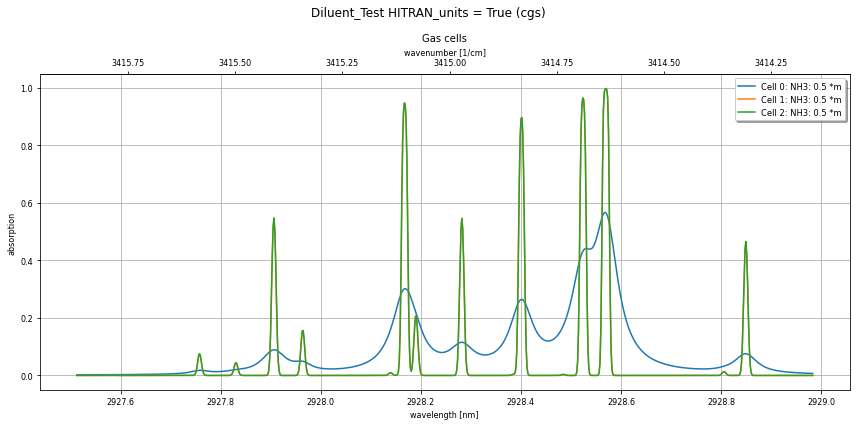

In [34]:
my_diluent_spectrum_hitran = copy.deepcopy(my_diluent_spectrum)
my_diluent_spectrum_hitran.name += ' HITRAN_units = True (cgs)'
# download again - with HITRAN unit True
with HiddenPrints():            # disables hapi stdout
    my_diluent_spectrum_hitran.download(line_list      = False,    #by setting to false, the linelist will nor be downloaded nor plotted.
                                        min_intensity = 5E-23,
                                        HITRAN_units = True)   # DOES NOT CHANGE ANYTHING :-)
    
# plot 
my_diluent_spectrum_hitran.plot()

Interpretation: When gamma-parameter not known, it is set to 0. Thus, no collisional broadnening. The linewidth is now natrual linewidth and doppler (dependen on Temperature).